In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore") #supress warnings for readability

In [2]:
#import csv
orig_url = "https://drive.google.com/file/d/1aVcCTw1vy-66D7ShjXACjV4hE4CDknDL/view?usp=sharing"
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text

csv_r = StringIO(url)
stats_adv = pd.read_csv(csv_r)
#replace A with space
stats_adv['Name'] = stats_adv['Name'].str.replace('Â',"")
stats_adv['Name'] = stats_adv['Name'].str.replace('Alexis DÃaz',"Alexis Diaz")


In [3]:
#import advanced stats csv
orig_url = "https://drive.google.com/file/d/1QQle4eS5BGTNWhcxjIRusJTBwjhdwyVD/view?usp=sharing"
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text

csv_raw = StringIO(url)
stats = pd.read_csv(csv_raw)
#replace A with space
stats['Name'] = stats['Name'].str.replace('Â',"")
stats['Name'] = stats['Name'].str.replace('Alexis DÃaz',"Alexis Diaz")


In [4]:
#Selecting columns we need
st = stats[['Name','Tm','IP','ERA+']]
sta = stats_adv[['Name','Tm','HardH%']]



In [5]:
#find null values
stats_adv.isnull().sum()
stats.isnull().sum()


ï»¿Rk      0
Name       0
Age        0
Tm         0
Lg         0
W          0
L          0
W-L%     147
ERA        0
G          0
GS         0
GF         0
CG         0
SHO        0
SV         0
IP         0
H          0
R          0
ER         0
HR         0
BB         0
IBB        0
SO         0
HBP        0
BK         0
WP         0
BF         0
ERA+      35
FIP        0
WHIP       0
H9         0
HR9        0
BB9        0
SO9        0
SO/W      33
dtype: int64

In [6]:
#delete rows with null values
st=st.dropna()
sta=sta.dropna()

In [7]:
#Combine the two dataframes 
merged_inner = pd.merge(left=st, right=sta, left_on='Name', right_on='Name')
merged_inner = merged_inner.drop(['Tm_y'], axis=1)

#filter players that played for multiple teams
max_teams = merged_inner.groupby('Name').idxmax()
merged_inner = merged_inner.groupby(['Name']).max().reset_index()

#delete rows with IP less than 50   
merged_inner = merged_inner[merged_inner['IP'] > 50]

#convert hardh% to float
merged_inner['HardH%'] = merged_inner['HardH%'].str.rstrip('%').astype('float') / 100.0

#sort by players with ERA+ under 150 and HardH% under 40
merged_inner[merged_inner['ERA+'] < 150].sort_values(by=['HardH%'], ascending=False)

merged_inner['Name'] = merged_inner['Name'].str.replace('Ã',"i")

merged_inner


,Name,Tm_x,IP,ERA+,HardH%
1,Aaron Ashby*,MIL,107.1,89.0,0.347
4,Aaron Civale,CLE,97.0,78.0,0.405
6,Adam Cimber,TOR,70.2,139.0,0.388
8,Adrian Houser,MIL,102.2,83.0,0.418
11,Alexis Di­az,CIN,63.2,244.0,0.331
...,...,...,...,...,...
366,Yu Darvish,SDP,194.2,121.0,0.373
367,Zach Davies,ARI,134.1,98.0,0.347
368,Zach Eflin,PHI,75.2,101.0,0.313
371,Zack Greinke,KCR,137.0,111.0,0.396


In [8]:
#sort columns
mg=merged_inner.sort_values(["ERA+","HardH%"],ascending=[False,True])
#delete the row with rasiel iglesias because he is an outlier
mg = mg.drop([mg.index[0]])

Text(0.5, 1.0, 'ERA+ vs. HardH%')

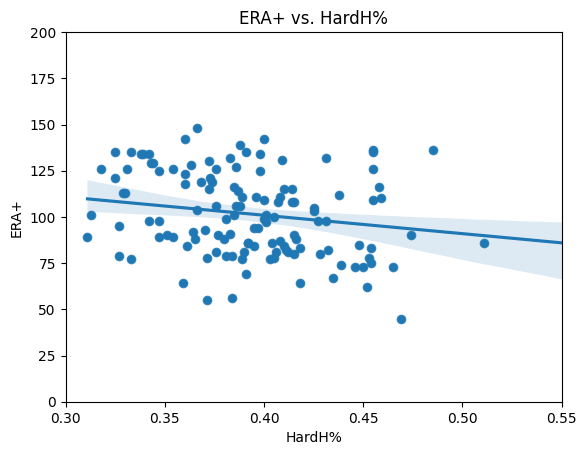

In [9]:
#visual showing players with ERA+ over 150 and HardH% over 45
sns.scatterplot(x='HardH%', y='ERA+', data=merged_inner[merged_inner['ERA+'] < 150])

# set the x and y limits
plt.ylim(0, 200)  
plt.xlim(0.30,0.55)

#add trendline
sns.regplot(x='HardH%', y='ERA+', data=merged_inner[merged_inner['ERA+'] < 150])
#add title
plt.title('ERA+ vs. HardH%')



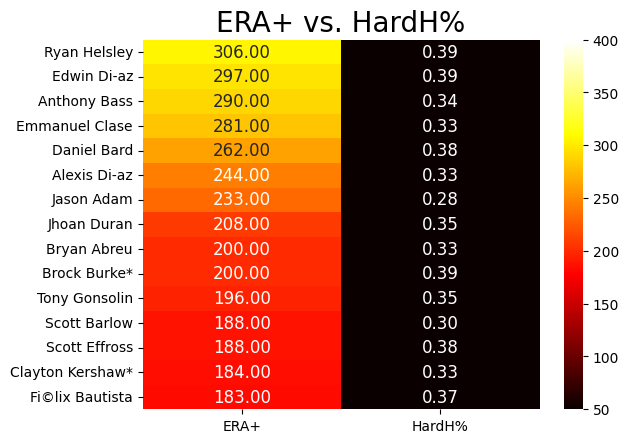

In [10]:
#create heatmap
hp = sns.heatmap(mg.head(15)[['ERA+','HardH%']], annot=True, annot_kws={'size': 12},fmt=".2f",vmin=50, vmax=400, cmap='hot')
hp.set_yticklabels(mg['Name'].head(15), rotation=0)
hp.set_title('ERA+ vs. HardH%', fontsize=20)
plt.show()


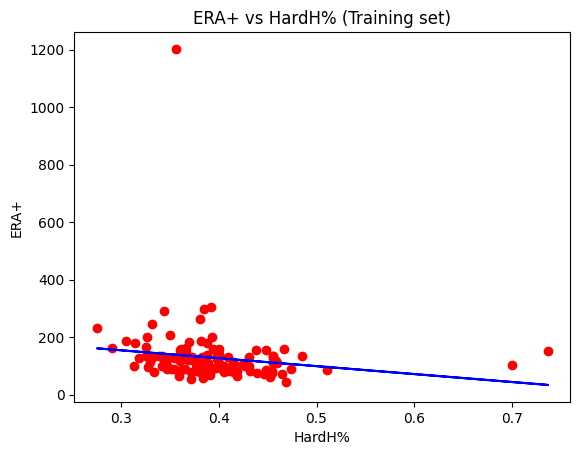

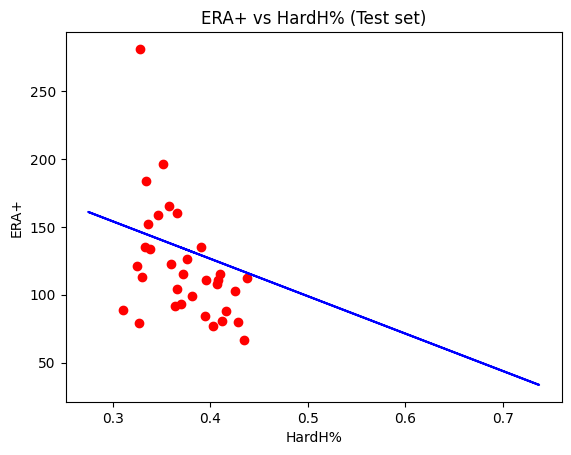

[[-275.71929296]]
[236.81485647]
Mean squared error: 1627.92
Variance score: 0.08


In [11]:
#split data into training and testing
X = merged_inner['HardH%'].values.reshape(-1,1)
y = merged_inner['ERA+'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

#predict the test set results
y_pred = regressor.predict(X_test)

#visualize the training set results
plt.scatter(X_train, y_train, color='red')
plt.plot(X_train, regressor.predict(X_train), color='blue')
plt.title('ERA+ vs HardH% (Training set)')
plt.xlabel('HardH%')
plt.ylabel('ERA+')
plt.show()

#visualize the test set results
plt.scatter(X_test, y_test, color='red')
plt.plot(X_train, regressor.predict(X_train), color='blue')
plt.title('ERA+ vs HardH% (Test set)')
plt.xlabel('HardH%')
plt.ylabel('ERA+')
plt.show()

#coefficients
print(regressor.coef_)
#intercept
print(regressor.intercept_)
#mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
#r2 score
print('Variance score: %.2f' % r2_score(y_test, y_pred))


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5d6c6614-8a04-4fb8-a24c-860b351869bd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>